# **Clustering**

### **Import** section

In [1]:
from random import sample
import numpy as np
import pandas as pd
import itertools
pd.set_option('display.expand_frame_repr', False)

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
import seaborn as sns
sns.set(style="ticks", color_codes=True)

from sklearn.cluster import KMeans, DBSCAN

---
### Text **normalization**

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import re

#nltk.download('stopwords')
#nltk.download('punkt')
ps = PorterStemmer()

def itemParser(s):
    
    s = s.replace("\n", "")
    s = re.sub(r'[^\w\s]', '', s)
    s = re.sub(r"(\d)", "", s)
    s = re.sub(r'\([^)]*\)', '', s)
    s = re.sub(u'\w*\u2122', '', s)

    s = s.lower()

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(s)

    filtered_sentence = [ps.stem(w) for w in word_tokens if not w in stop_words]
    s = ' '.join(filtered_sentence)
    
    return s

---
## **Read** dataset and **Mapping**

In [3]:
superm = []
baskets = []
with open('../Data/groceries_norm.csv', 'r') as f:
    for line in f:
        basket = []
        line = line.replace('\n', '')
        items = line.split(",")
        for item in items:
            #parsed = itemParser(item)
            superm.append(item)
            basket.append(item)
        baskets.append(basket)

In [4]:
products = list(set(superm))

In [5]:
# Mapping
elems = set()
for b in baskets:
    elems.update(b)

mapping = {}
reverseMapping = {}
key = 0
for e in elems:
    mapping[e] = key
    reverseMapping[key] = e
    key += 1

In [6]:
singletons = {}
for b in baskets:
    for item in b:
        if item not in singletons.keys():
            singletons[item] = 0
        singletons[item] += 1

---
### Dataset **Transformations** - (*One Hot Encoder*)

In [7]:
ohe_baskets = []
for basket in baskets:
    ohe = [0 for _ in range(len(mapping))]
    for item in basket:
        ohe[mapping[item]] = 1
    ohe_baskets.append(ohe)

In [8]:
pd_ohe = pd.DataFrame(ohe_baskets)
display(pd_ohe)

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,167,168
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9830,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
9831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
## **Tests**

### Basket size count

In [9]:
maxlen = 0
for b in baskets:
    if len(b) > maxlen:
        maxlen = len(b)
        
count = [0 for _ in range(maxlen + 1)]
for b in baskets:
    count[len(b)] += 1

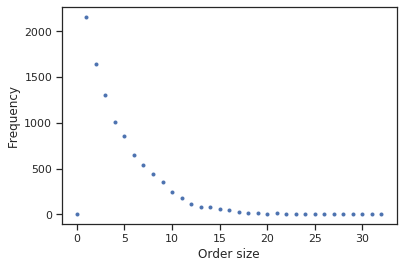

In [10]:
plt.ylabel("Frequency")
plt.xlabel("Order size")
plt.plot(count, ".")

### **PCA** > Clustering

In [13]:
pca = PCA(n_components=5)
pcat = pca.fit_transform(pd_ohe)
principalDf = pd.DataFrame(data=pcat)

In [14]:
display(principalDf)

,0,1,2,3,4
0,-0.268474,-0.179030,0.156737,-0.078277,0.178286
1,-0.008960,-0.027805,0.187710,0.001975,0.997707
2,0.065762,-0.659545,-0.503726,0.168407,-0.213477
3,-0.049957,-0.076297,0.183861,-0.019412,0.879885
4,0.553859,-0.560638,0.125215,-0.018027,-0.612403
...,...,...,...,...,...
9830,1.317922,-0.338629,0.000235,0.167800,-0.010064
9831,-0.519433,-0.218625,0.046011,-0.066114,0.005443
9832,0.830981,0.542484,0.407093,-0.890994,0.350635
9833,-0.387953,0.580180,-0.047331,0.785927,-0.078567


#### Analysis

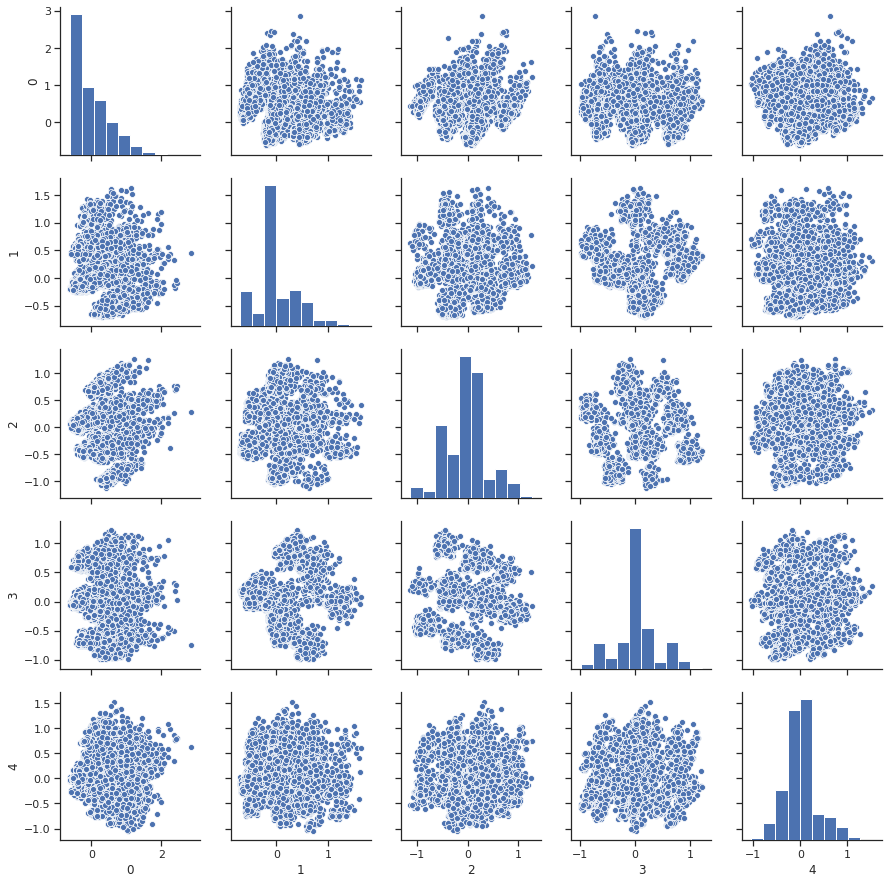

In [15]:
g = sns.pairplot(principalDf)

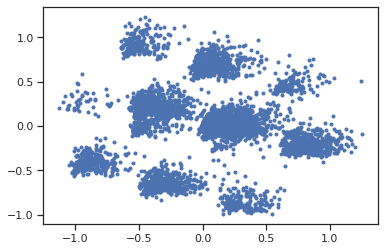

In [21]:
# Details
xx = list(principalDf[2])
yy = list(principalDf[3])

plt.scatter(xx, yy, marker=".")

### **KMeans**

In [16]:
'''
kmeans = KMeans(n_clusters=10).fit(interessanti)
centroids = kmeans.cluster_centers_
print(centroids)
'''

'\nkmeans = KMeans(n_clusters=10).fit(interessanti)\ncentroids = kmeans.cluster_centers_\nprint(centroids)\n'

In [18]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(principalDf)
    distortions.append(kmeanModel.inertia_)

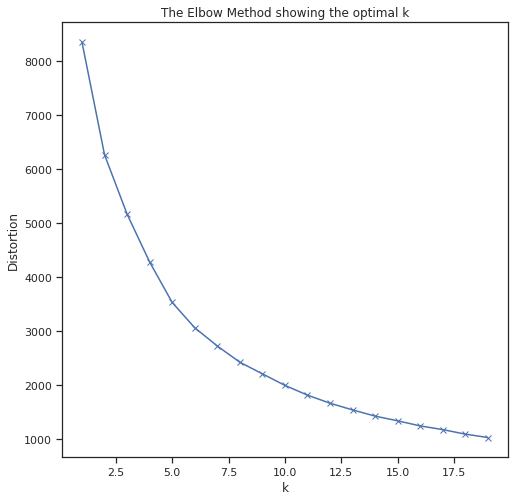

In [19]:
plt.figure(figsize=(8, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [20]:
kmeanModel = KMeans(n_clusters=12)
kmeanModel.fit(principalDf)
predicted = list(kmeanModel.predict(principalDf))

In [21]:
principalDf['Cluster'] = pd.Series(predicted)

In [24]:
display(principalDf)

,0,1,2,3,4,Cluster
0,-0.268474,-0.179030,0.156737,-0.078277,0.178286,2
1,-0.008960,-0.027805,0.187710,0.001975,0.997707,0
2,0.065762,-0.659545,-0.503726,0.168407,-0.213477,7
3,-0.049957,-0.076297,0.183861,-0.019412,0.879885,0
4,0.553859,-0.560638,0.125215,-0.018027,-0.612403,3
...,...,...,...,...,...,...
9830,1.317922,-0.338629,0.000235,0.167800,-0.010064,10
9831,-0.519433,-0.218625,0.046011,-0.066114,0.005443,2
9832,0.830981,0.542484,0.407093,-0.890994,0.350635,11
9833,-0.387953,0.580180,-0.047331,0.785927,-0.078567,5


### **DBSCAN**

In [54]:
dataset = principalDf[[0,1,2,3,4]]
display(dataset)

,0,1,2,3,4
0,-0.268512,-0.176835,0.158320,-0.076558,0.181882
1,-0.008952,-0.027810,0.187328,0.001125,0.998558
2,0.065764,-0.659633,-0.503899,0.168351,-0.214104
3,-0.049946,-0.074632,0.182944,-0.017850,0.877155
4,0.553862,-0.560695,0.124966,-0.017896,-0.612327
...,...,...,...,...,...
9830,1.317846,-0.337602,0.007040,0.169374,0.020229
9831,-0.519436,-0.218599,0.046236,-0.066111,0.005637
9832,0.830960,0.543217,0.405524,-0.890827,0.358662
9833,-0.387953,0.580323,-0.047412,0.785228,-0.082243


In [55]:
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(dataset)

In [56]:
#np.unique(dbscan)
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('n clust:', n_clusters_)
print('n noise:', n_noise_)

n clust: 6
n noise: 5


In [58]:
principalDf['DB_Scan'] = pd.Series(labels)

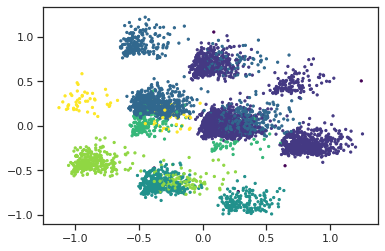

In [32]:
xx = list(principalDf[2])
yy = list(principalDf[3])

plt.scatter(xx, yy, c=labels, s=5, cmap='viridis')

In [25]:
principalDf.to_pickle("../Data/Clustered_Basket.pkl")
# File read by Basket-Recipes

---
## Clustering **Analysis**

In [26]:
clusteredBasket = list(zip(baskets, predicted))

In [45]:
def countItems(lista, top):
    counting = {}
    for items in lista:
        for item in items:
            if item not in counting.keys():
                counting[item] = 0
            counting[item] += 1
            
    counting = [(k, v) for k, v in sorted(counting.items(), key=lambda item: item[1], reverse=True)]
    tops = counting[:top]
    
    for (k, v) in tops:
        print("      " + str(k) + " [" + str(v) + "]")
        
    return tops

In [28]:
pdClusteredBasket = pd.DataFrame(clusteredBasket, columns=["Basket", "Cluster"])
pdClusteredBasket

,Basket,Cluster
0,"[citru fruit, semifinish bread, margarin, read...",2
1,"[tropic fruit, yogurt, coffe]",0
2,[whole milk],7
3,"[pip fruit, yogurt, cream chees, meat spread]",0
4,"[veget, whole milk, condens milk, long life ba...",3
...,...,...
9830,"[sausag, chicken, beef, hamburg meat, citru fr...",10
9831,[cook chocol],2
9832,"[chicken, citru fruit, veget, butter, yogurt, ...",11
9833,"[semifinish bread, bottl water, soda, bottl beer]",5


In [29]:
# Single Cluster Analysis
clusters = []
for i in range(10):
    clusters.append(pdClusteredBasket.loc[pdClusteredBasket['Cluster'] == i]) 

In [83]:
# Top 10 cluster items



unique_labels = []
all_tops = []

for i in range(10):
    print("Cluster " + str(i+1) + ":")
    tops = countItems(list(clusters[i]["Basket"]), 10)
    all_tops.append(tops)
    for item in tops:
        unique_labels.append(str(item[0]))

unique_labels = set(unique_labels)

count = {}
for unique_item in unique_labels:
    count[unique_item] = []
    
for t in all_tops:
    content = [x[0] for x in t]
    counting = [x[1] for x in t]
    for product in unique_labels:
        
        index = 0
        found = False
        for c in content:
            if c == product:
                found = True
                count[product].append(counting[index])
            index += 1
            
        if not found:
            count[product].append(0)    

final = []
for k in count:
    final.append(count[k])

Cluster 1:
      yogurt [483]
      tropic fruit [175]
      bottl water [132]
      citru fruit [123]
      pip fruit [91]
      shop bag [76]
      fruitveget juic [75]
      root veget [70]
      brown bread [66]
      sausag [62]
Cluster 2:
      rollsbun [741]
      sausag [92]
      frankfurt [77]
      newspap [67]
      yogurt [64]
      shop bag [61]
      tropic fruit [60]
      bottl water [59]
      can beer [56]
      pastri [55]
Cluster 3:
      can beer [458]
      bottl beer [322]
      shop bag [295]
      bottl water [267]
      pastri [220]
      newspap [216]
      coffe [188]
      sausag [187]
      root veget [169]
      citru fruit [146]
Cluster 4:
      whole milk [351]
      veget [346]
      root veget [107]
      domest egg [60]
      whippedsour cream [58]
      pip fruit [57]
      tropic fruit [54]
      pork [50]
      citru fruit [49]
      butter [43]
Cluster 5:
      soda [298]
      whole milk [297]
      veget [67]
      bottl water [63]
      pastr

In [105]:
count

{'frankfurt': [0, 77, 0, 0, 0, 0, 0, 0, 0, 0],
 'shop bag': [76, 61, 295, 0, 51, 116, 99, 0, 0, 49],
 'coffe': [0, 0, 188, 0, 0, 0, 0, 0, 0, 0],
 'can beer': [0, 56, 458, 0, 0, 77, 0, 0, 0, 0],
 'brown bread': [66, 0, 0, 0, 0, 0, 0, 91, 0, 0],
 'pip fruit': [91, 0, 0, 57, 0, 0, 90, 0, 0, 0],
 'whippedsour cream': [0, 0, 0, 58, 0, 0, 101, 89, 0, 0],
 'butter': [0, 0, 0, 43, 0, 0, 0, 0, 0, 0],
 'newspap': [0, 67, 216, 0, 0, 0, 0, 111, 47, 28],
 'bottl water': [132, 59, 267, 0, 63, 135, 0, 111, 46, 49],
 'fruitveget juic': [75, 0, 0, 0, 41, 74, 0, 0, 0, 0],
 'pastri': [0, 55, 220, 0, 62, 73, 0, 107, 47, 37],
 'soda': [0, 0, 0, 0, 298, 910, 0, 0, 0, 286],
 'sausag': [62, 92, 187, 0, 41, 75, 86, 0, 46, 76],
 'tropic fruit': [175, 60, 0, 54, 46, 52, 116, 106, 50, 30],
 'yogurt': [483, 64, 0, 0, 56, 0, 97, 117, 78, 53],
 'pork': [0, 0, 0, 50, 0, 0, 89, 0, 0, 0],
 'veget': [0, 0, 0, 346, 67, 54, 815, 0, 0, 41],
 'domest egg': [0, 0, 0, 60, 0, 0, 0, 94, 0, 0],
 'whole milk': [0, 0, 0, 351, 297,

In [188]:
final
cumulative = []
for f in final:
    cumulative.append(np.cumsum(f).tolist()[::-1])

In [134]:
final
tmp = []
for cluster in final:
    somma = sum(cluster)
    row = [x/somma for x in cluster]
    tmp.append(row)
    

In [135]:
finalT = np.array(tmp).T.tolist()

In [193]:
df = pd.DataFrame(cumulative).T
display(df)

vals = (df.div(df.sum(axis=0), axis=1)).values.tolist()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,77,747,188,591,157,238,248,43,469,862,...,948,139,1323,154,2077,1362,697,420,39,435
1,77,698,188,591,157,238,248,43,441,813,...,895,139,1282,154,2077,1076,697,420,39,435
2,77,698,188,591,157,238,248,43,394,767,...,817,139,1282,154,1742,741,647,420,0,435
3,77,698,188,591,66,238,159,43,283,656,...,700,139,1282,60,648,741,524,420,0,435
4,77,599,188,591,66,148,58,43,283,656,...,603,50,467,60,648,741,346,420,0,318
5,77,483,188,514,66,148,58,43,283,521,...,603,50,413,60,648,741,346,322,0,318
6,77,432,188,514,66,148,58,43,283,458,...,547,50,346,60,351,741,346,322,0,318
7,77,432,188,514,66,91,0,0,283,458,...,547,0,0,0,0,741,239,322,0,269
8,77,137,0,56,66,91,0,0,67,191,...,547,0,0,0,0,741,70,0,0,123
9,0,76,0,0,66,91,0,0,0,132,...,483,0,0,0,0,0,70,0,0,123


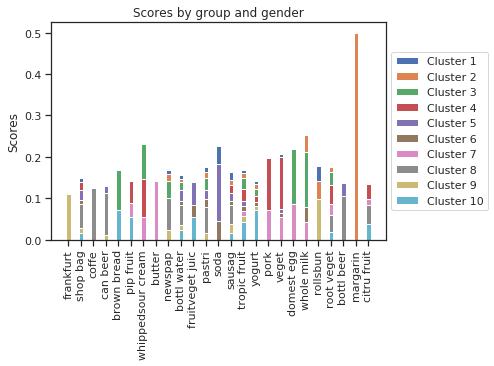

In [194]:
import numpy as np
import matplotlib.pyplot as plt


N = len(count)

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

for i in range(10):
    plt.bar(ind, vals[i], width)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, unique_labels, rotation='vertical')
#plt.yticks(np.arange(0, 81, 10))
plt.legend(["Cluster " + str(x) for x in range(1, 11)], loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()